In [1]:
# import pyforest
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        # print(f'tree_num: {tree_num}, test_proba_temp shape: {test_proba_temp.shape}')
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
        # print(f'test_proba0_df shape: {test_proba0_df.shape}, test_proba1_df shape: {test_proba1_df.shape}')
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)

    # print(f'in df tree prob function. std0 shape: {std0.shape}, std1 shape: {std1.shape}')
    return std0, std1

In [4]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [5]:
results_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
datapath='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']


In [6]:
for nek in neks: 
    for feat in feats: 
        for samp in samplings: 
            for rf in RF_types: 
                print(f'{nek} {feat} {samp} {rf}')
                root_name = f'{nek}_{feat}_{samp}'
                results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{rf}_prod_test.csv')
                data_df = pd.read_csv(f'{datapath}{root_name}.csv')
                with open(f'{results_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                    model = pickle.load(f) 
                train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ(results_df,data_df,model)
    
                

NEK2_binding MOE none_scaled RF


NameError: name 'get_plotting_data_RF_UQ' is not defined

In [20]:
def get_plotting_data_RF_UQ(results_df,data_df,model): 
    drop_cols=['NEK'	,'compound_id',	'base_rdkit_smiles',	'subset'	,'active']
    train_df=data_df[data_df['subset']=='train'].drop(columns=drop_cols) 
    test_df=data_df[data_df['subset']=='test'].drop(columns=drop_cols) 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    std0, std1=get_tree_probabilities(model, test_df)
    return train_dist, test_dist, std0, std1
 

In [21]:
# pred_markers = {'TP': 'o','TN': 's', 'FP': '^', 'FN': 'D'}
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}

In [43]:
def RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax):
    predictions = df['prediction']
    ad_dist=df['ADdist']
    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad]) 
    }
    data = pd.DataFrame(data)
    sizes = data['prediction_type'].map(pred_sizes)
    # 
    sns.scatterplot(data=data, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           markers=pred_markers,style='prediction_type',ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    ax.set_ylabel('std of probability', fontsize=15)
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,12) 



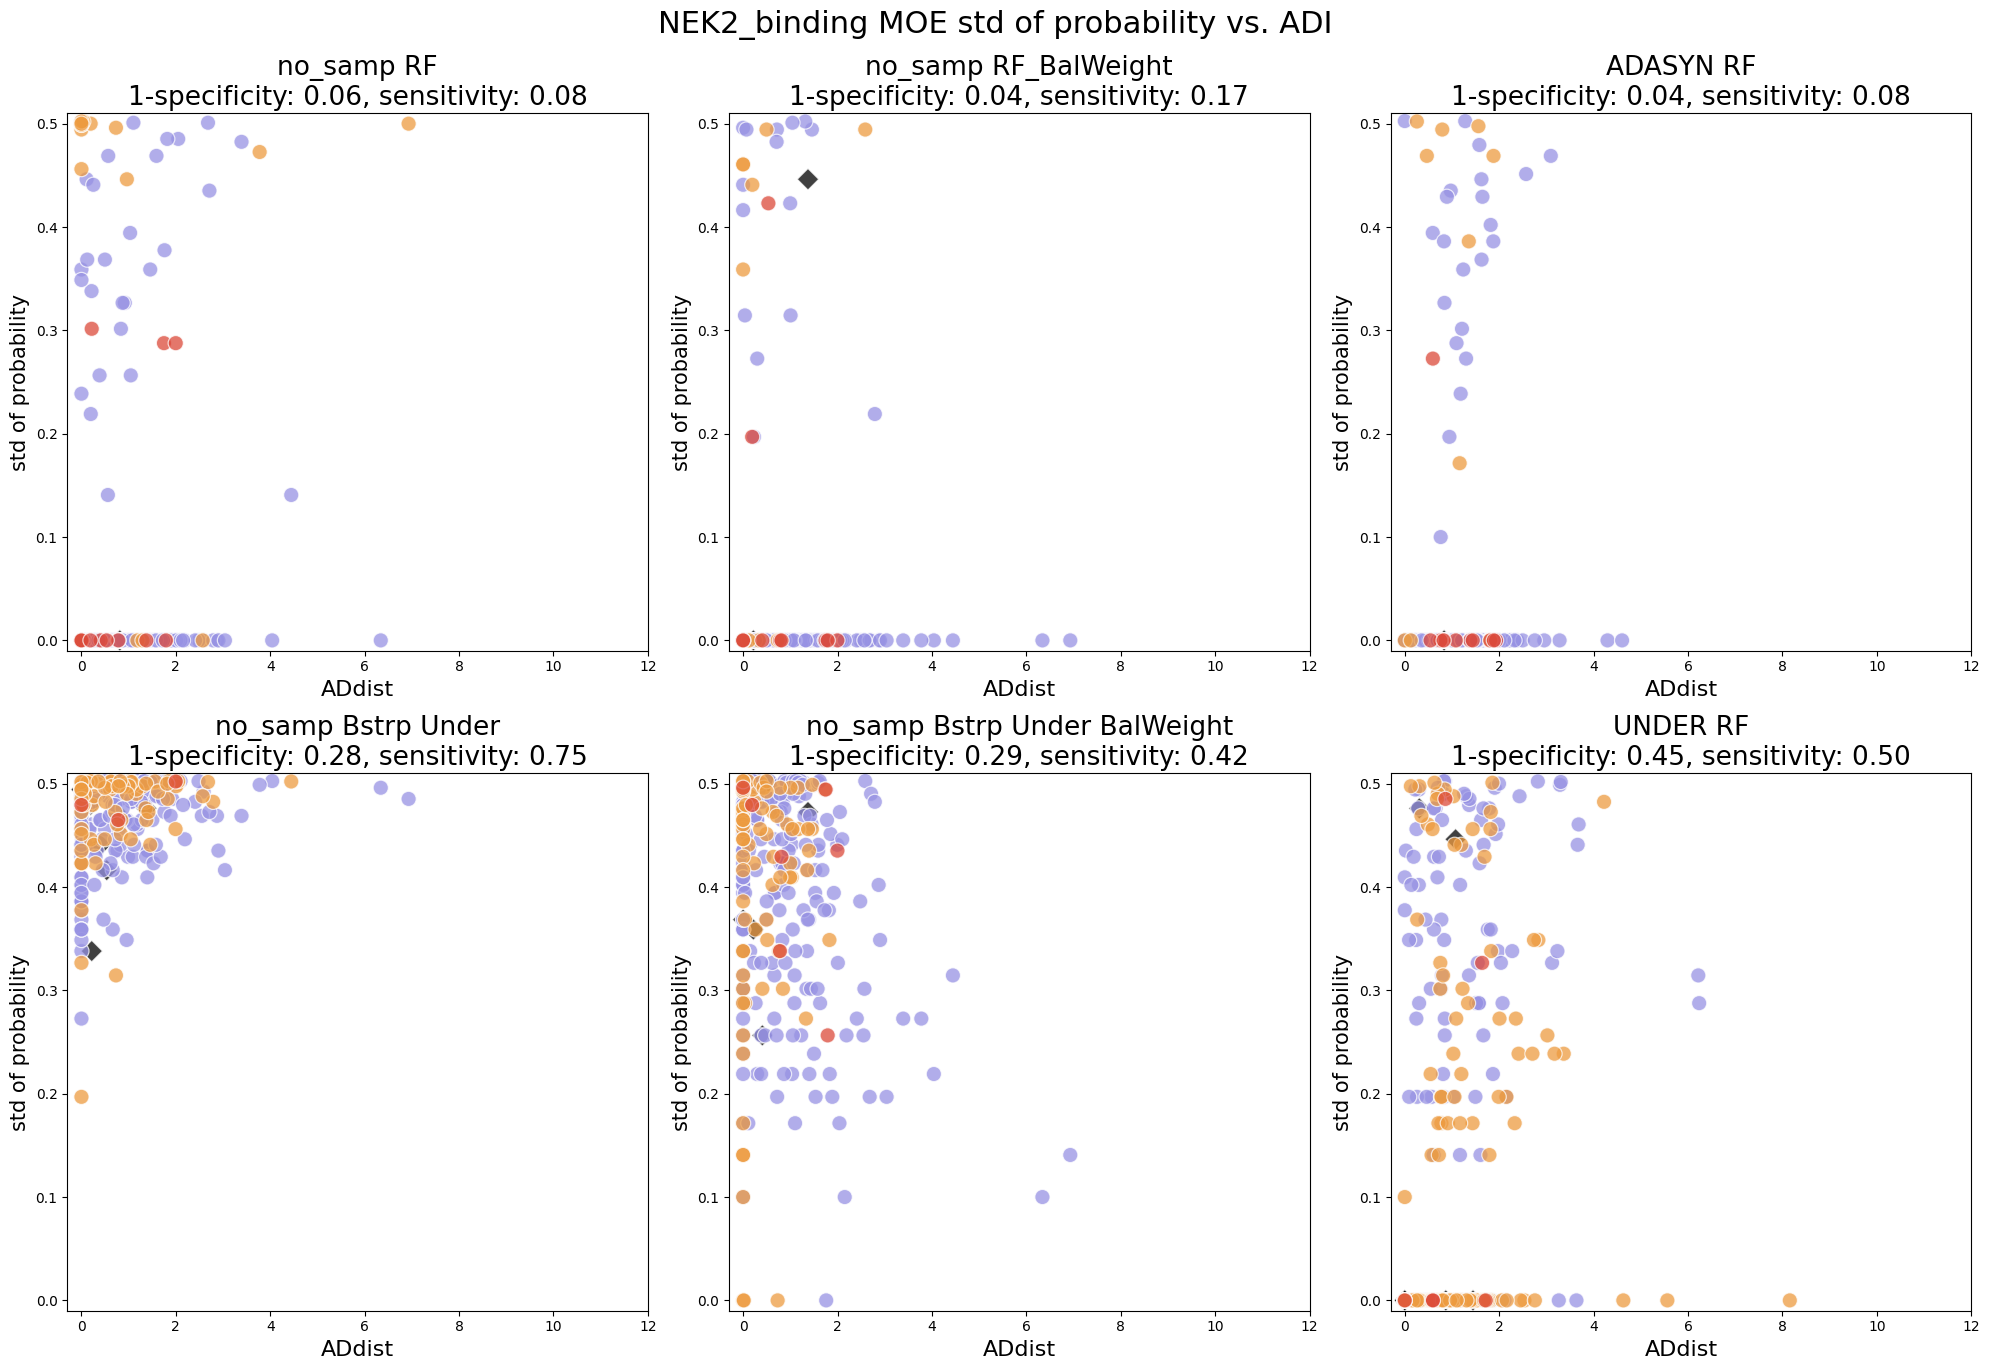

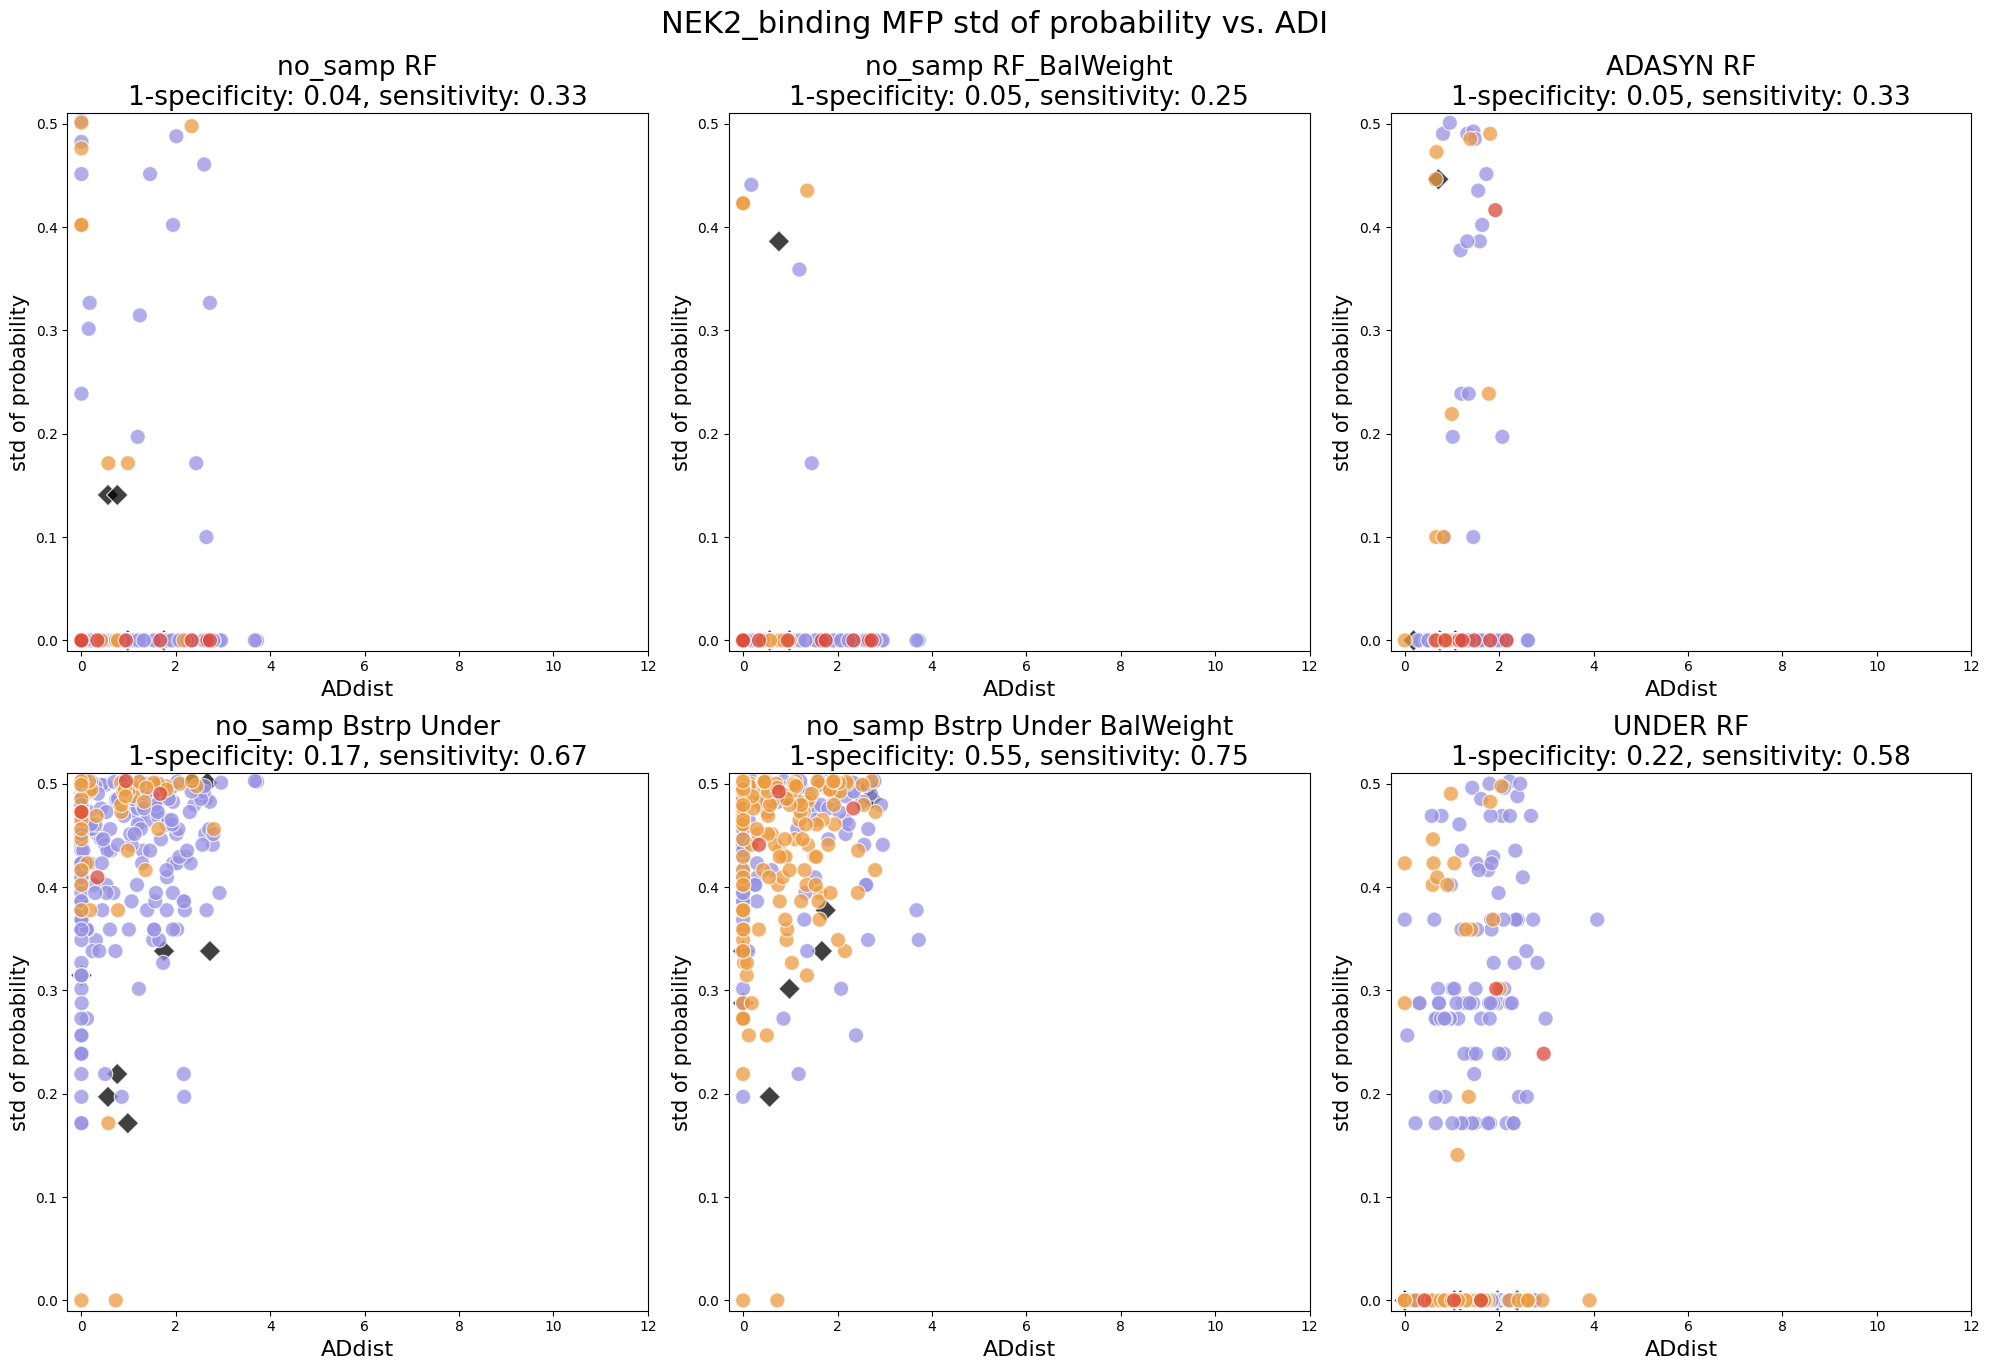

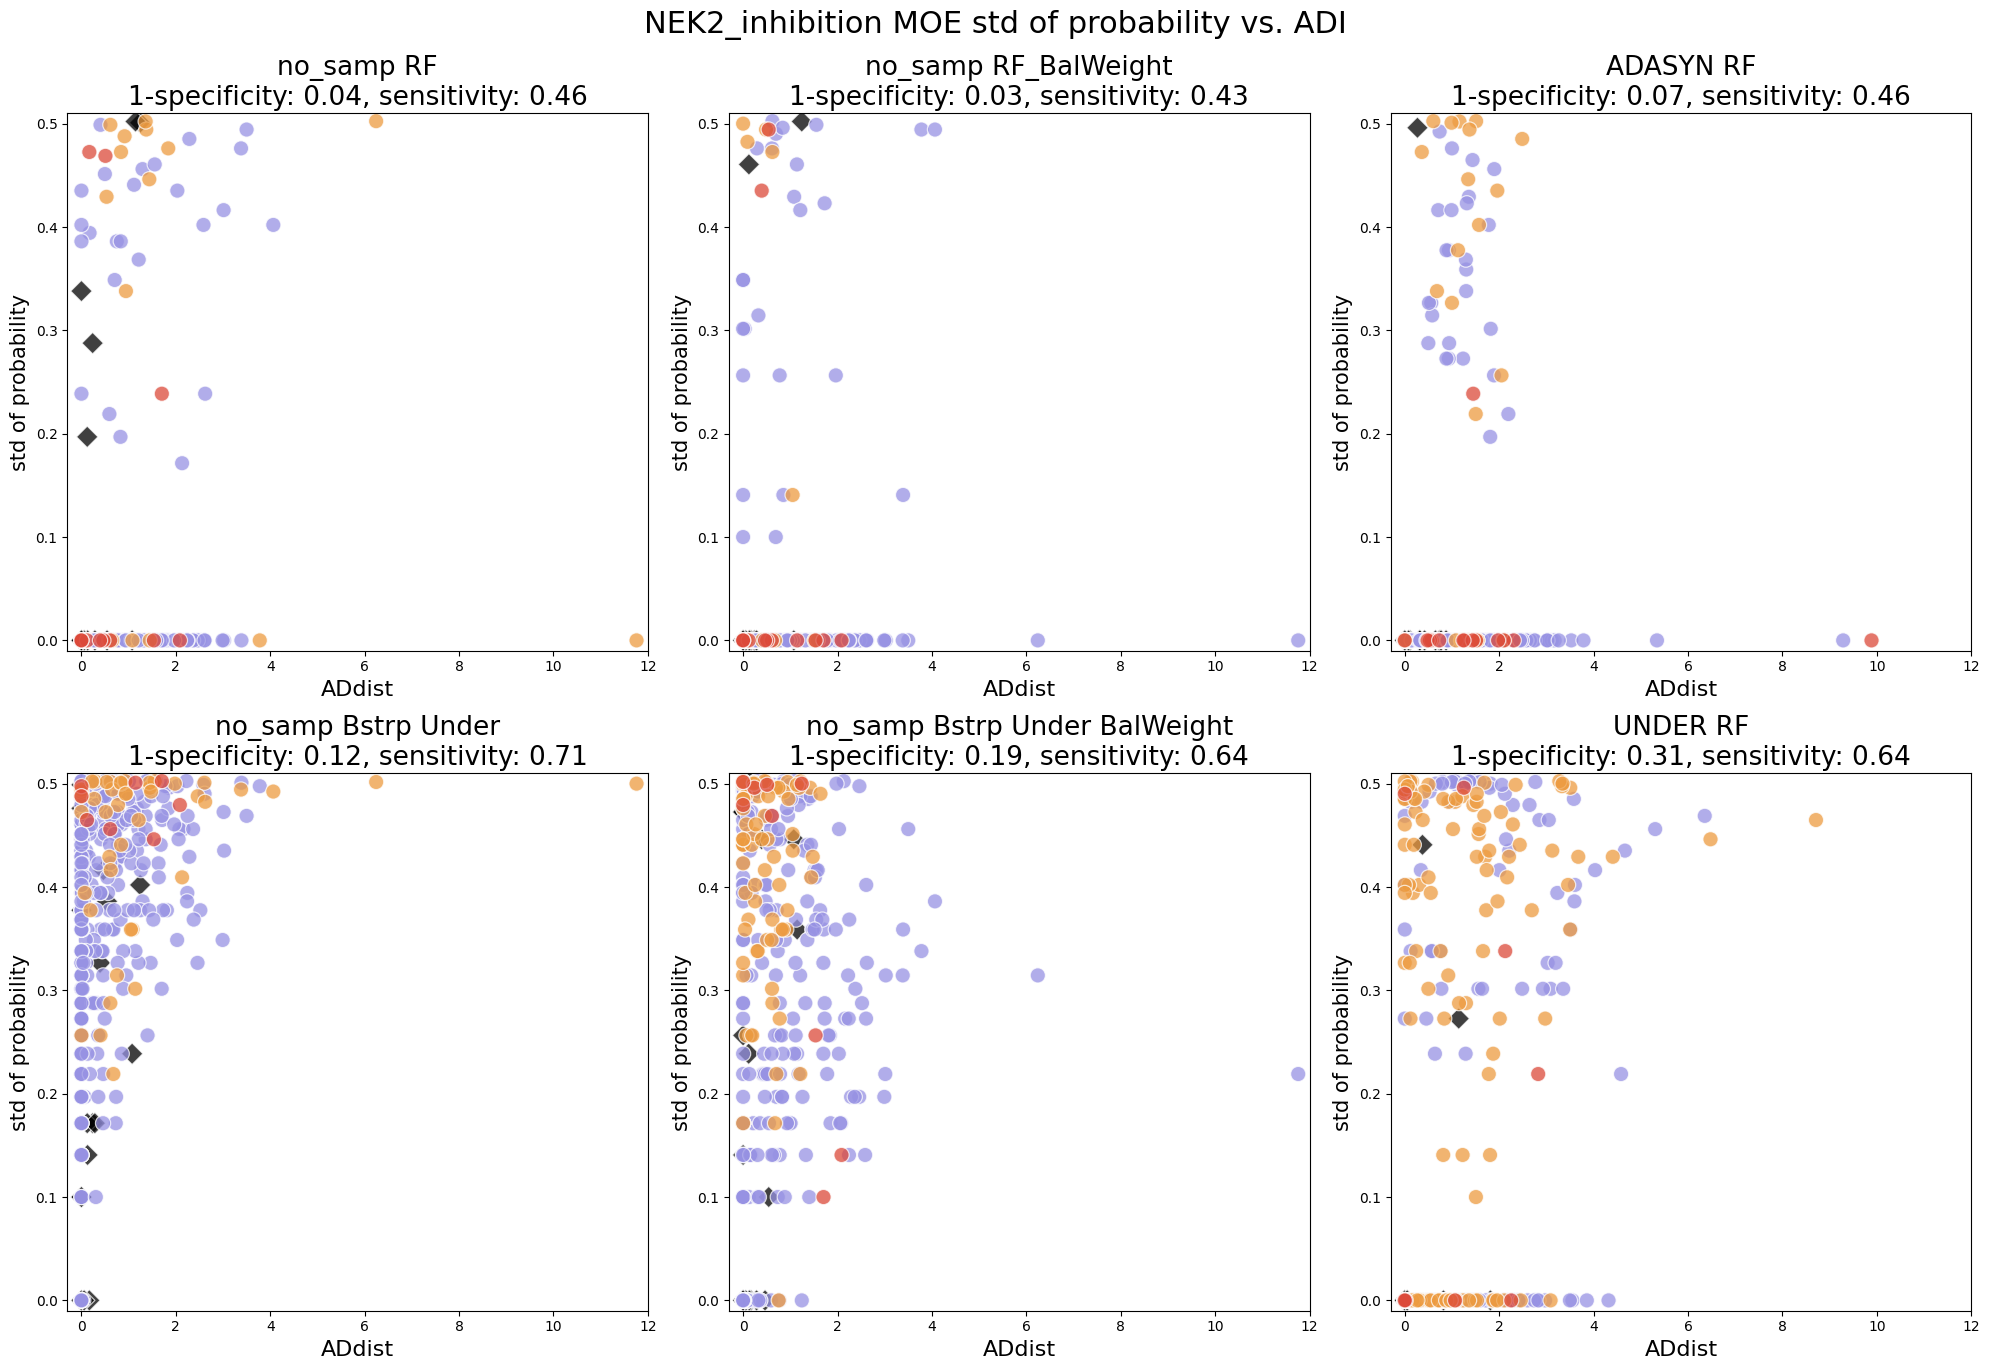

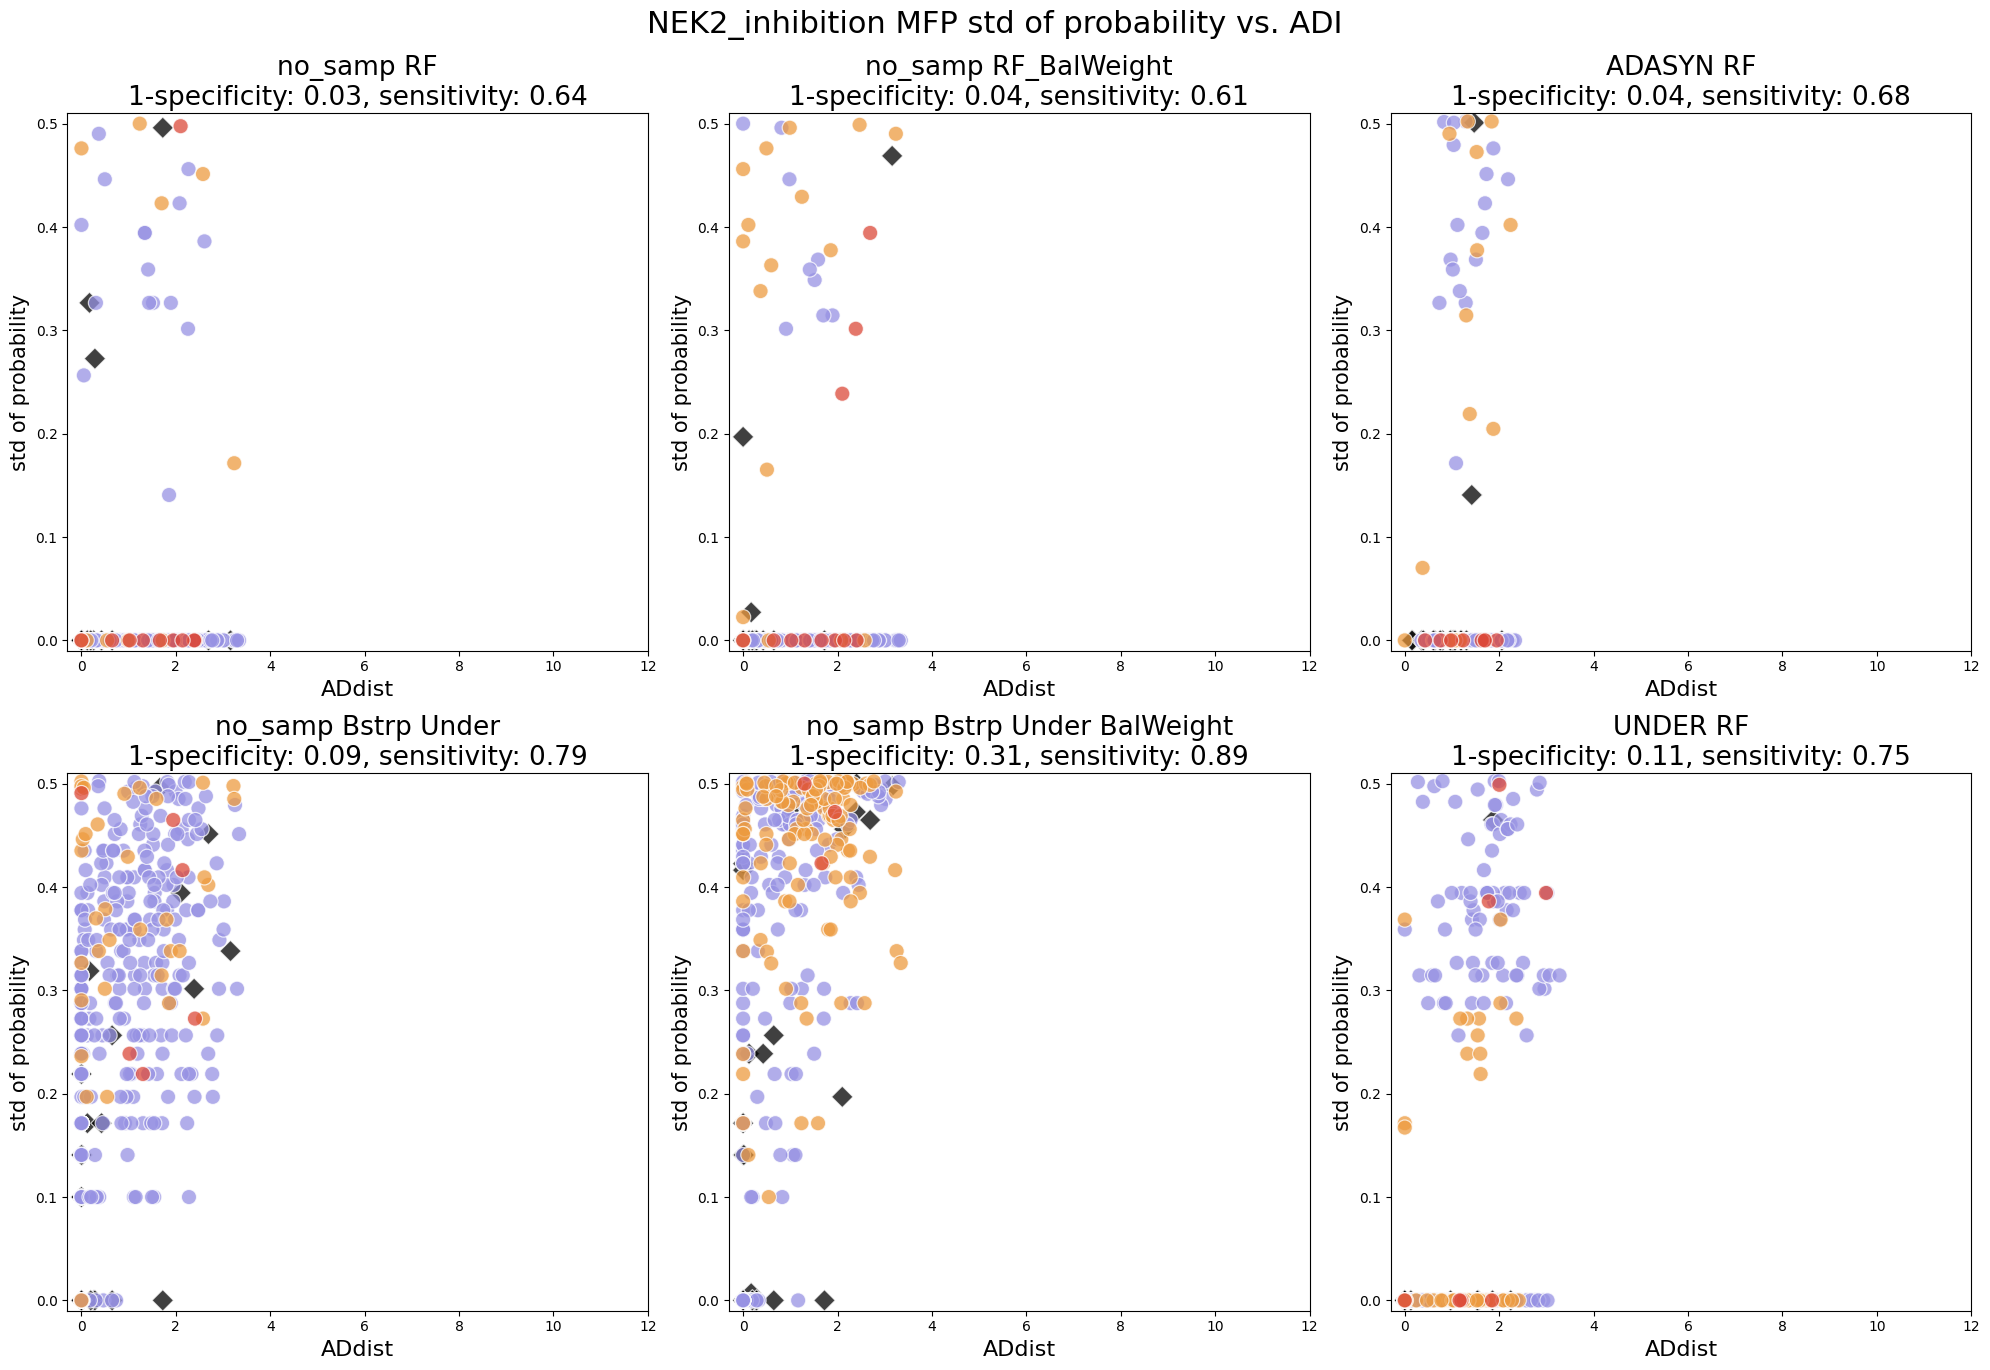

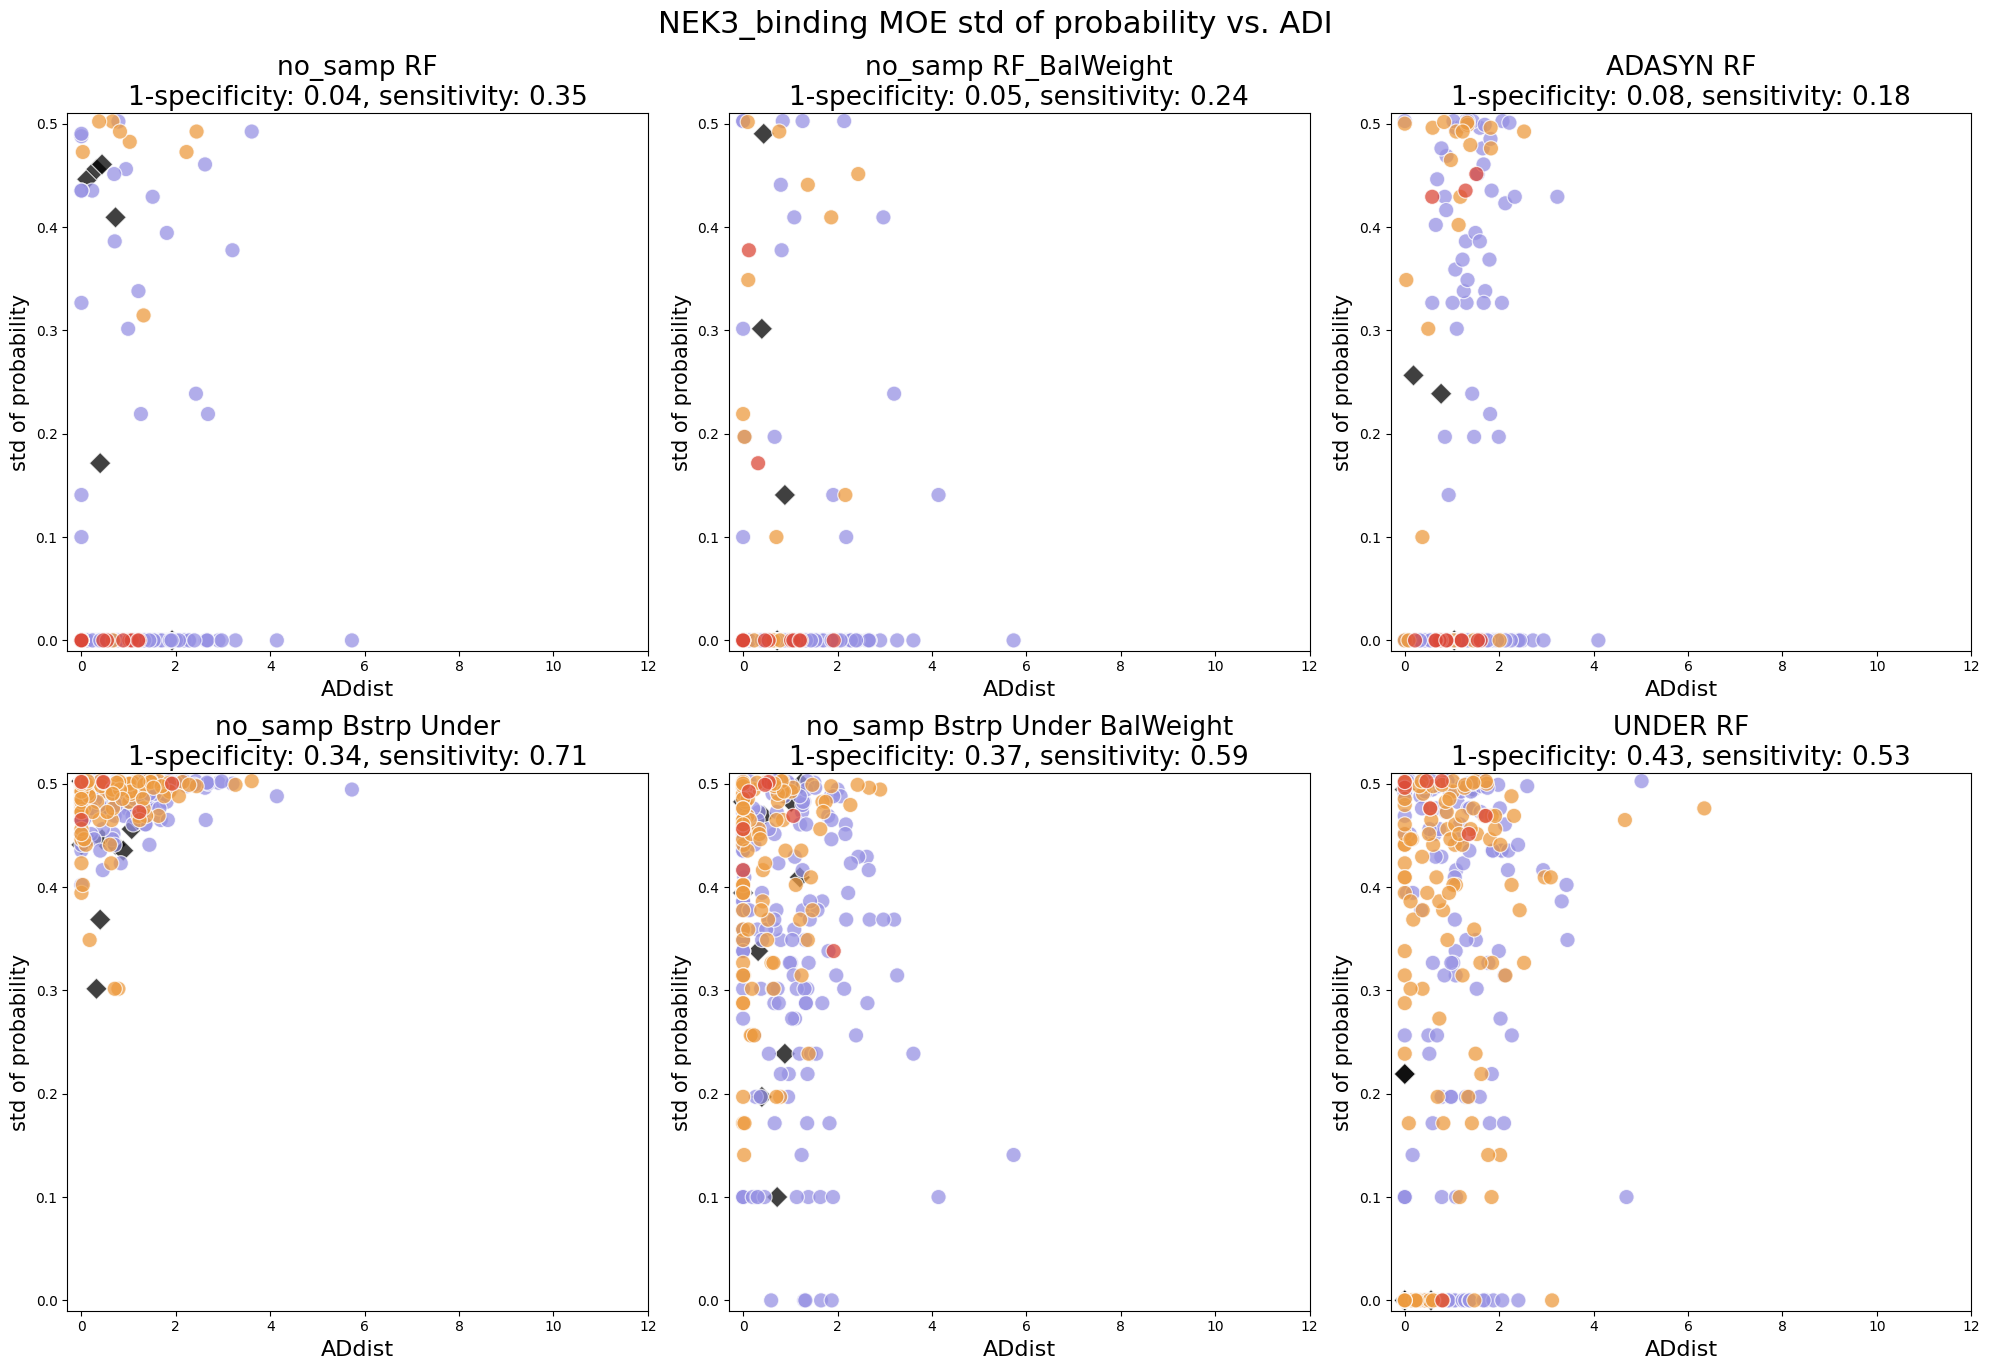

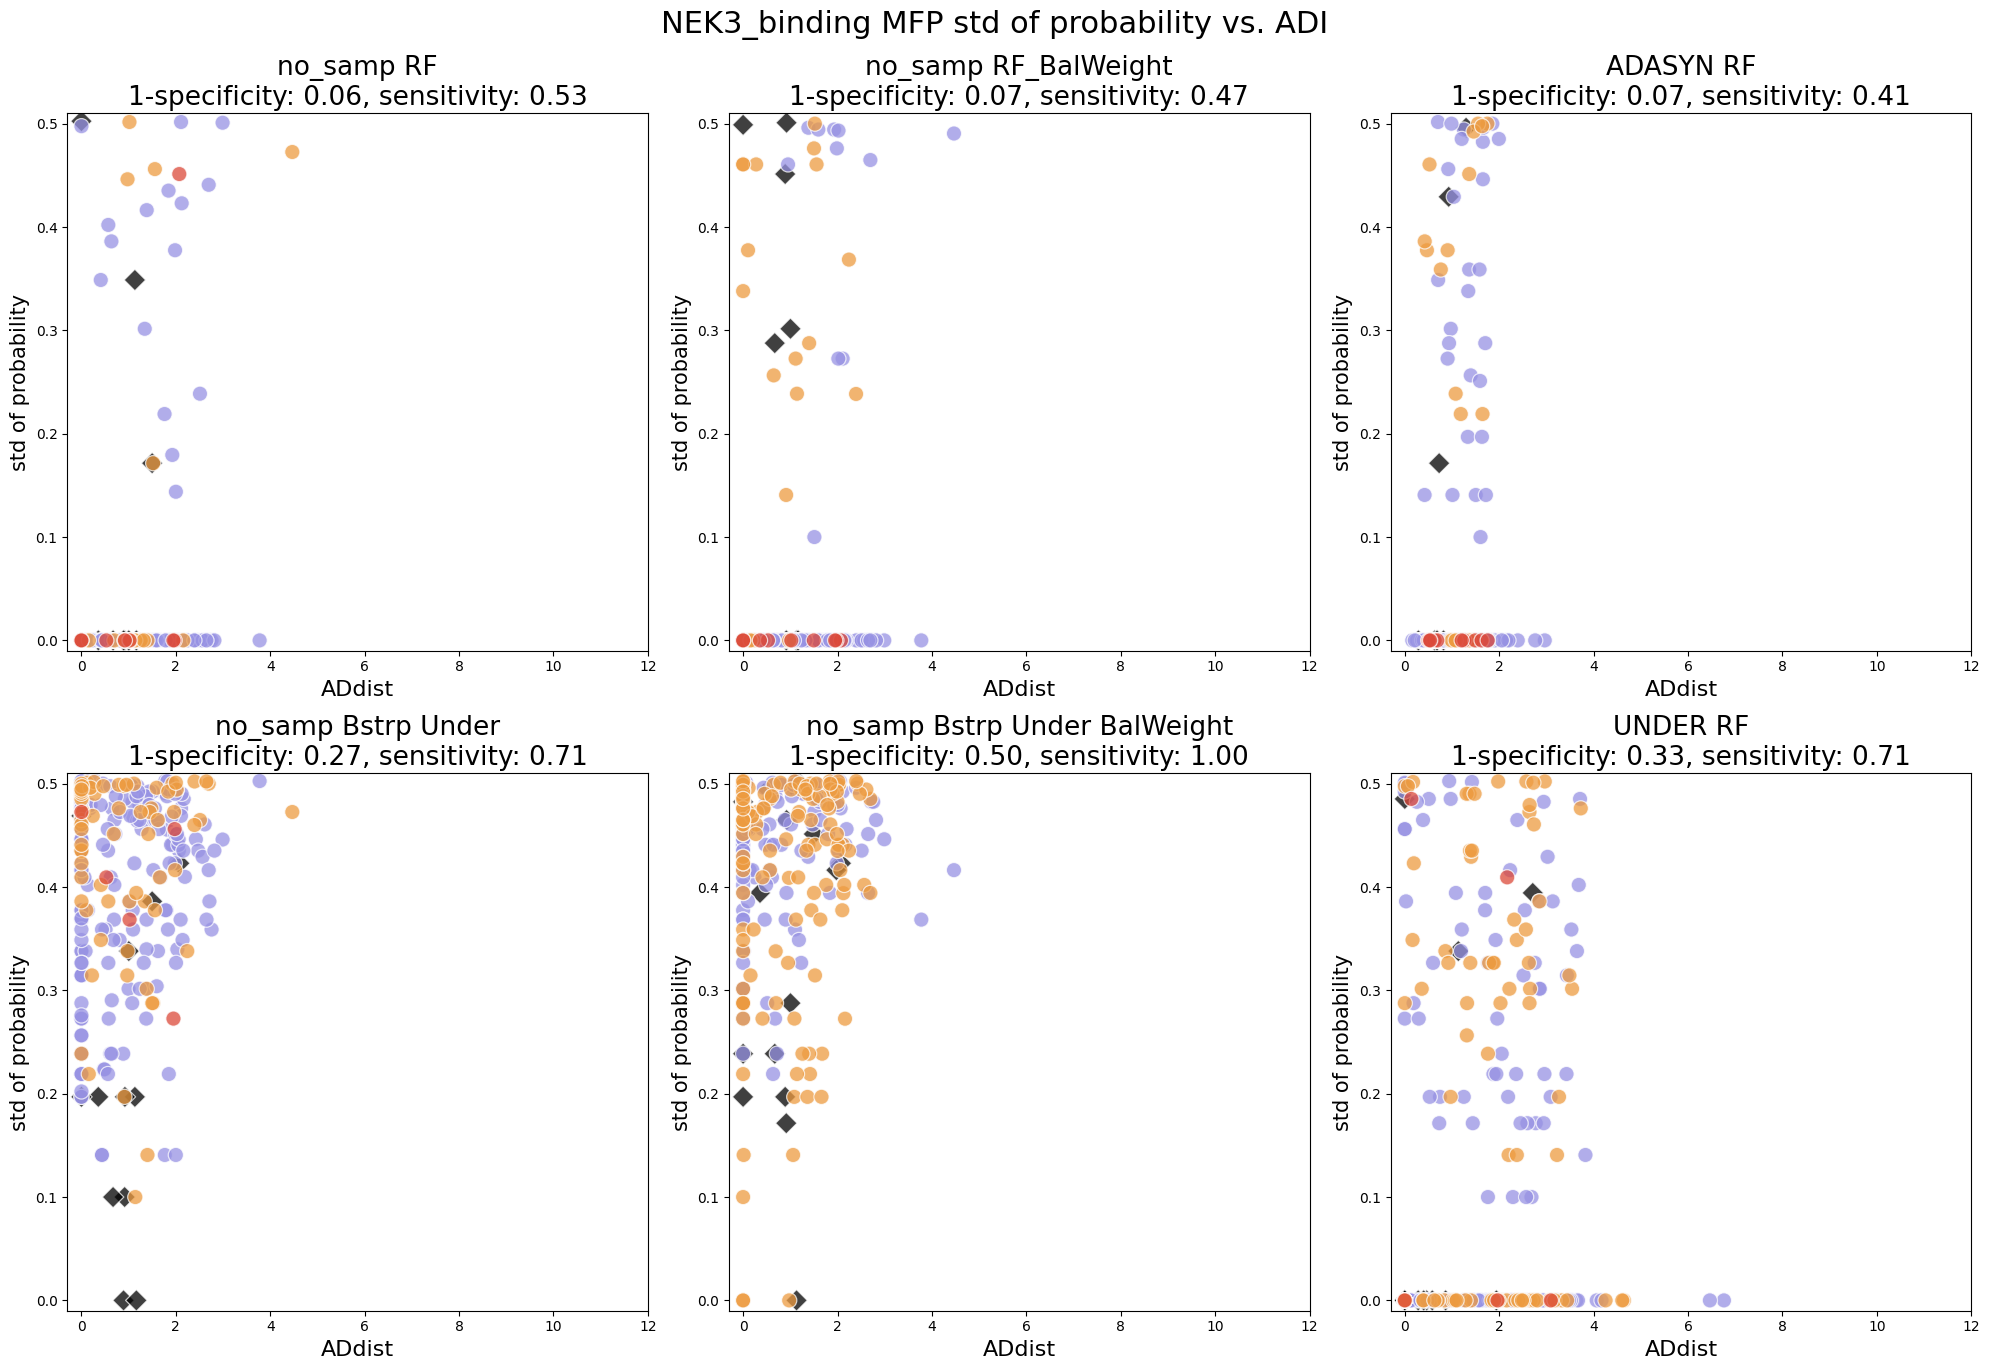

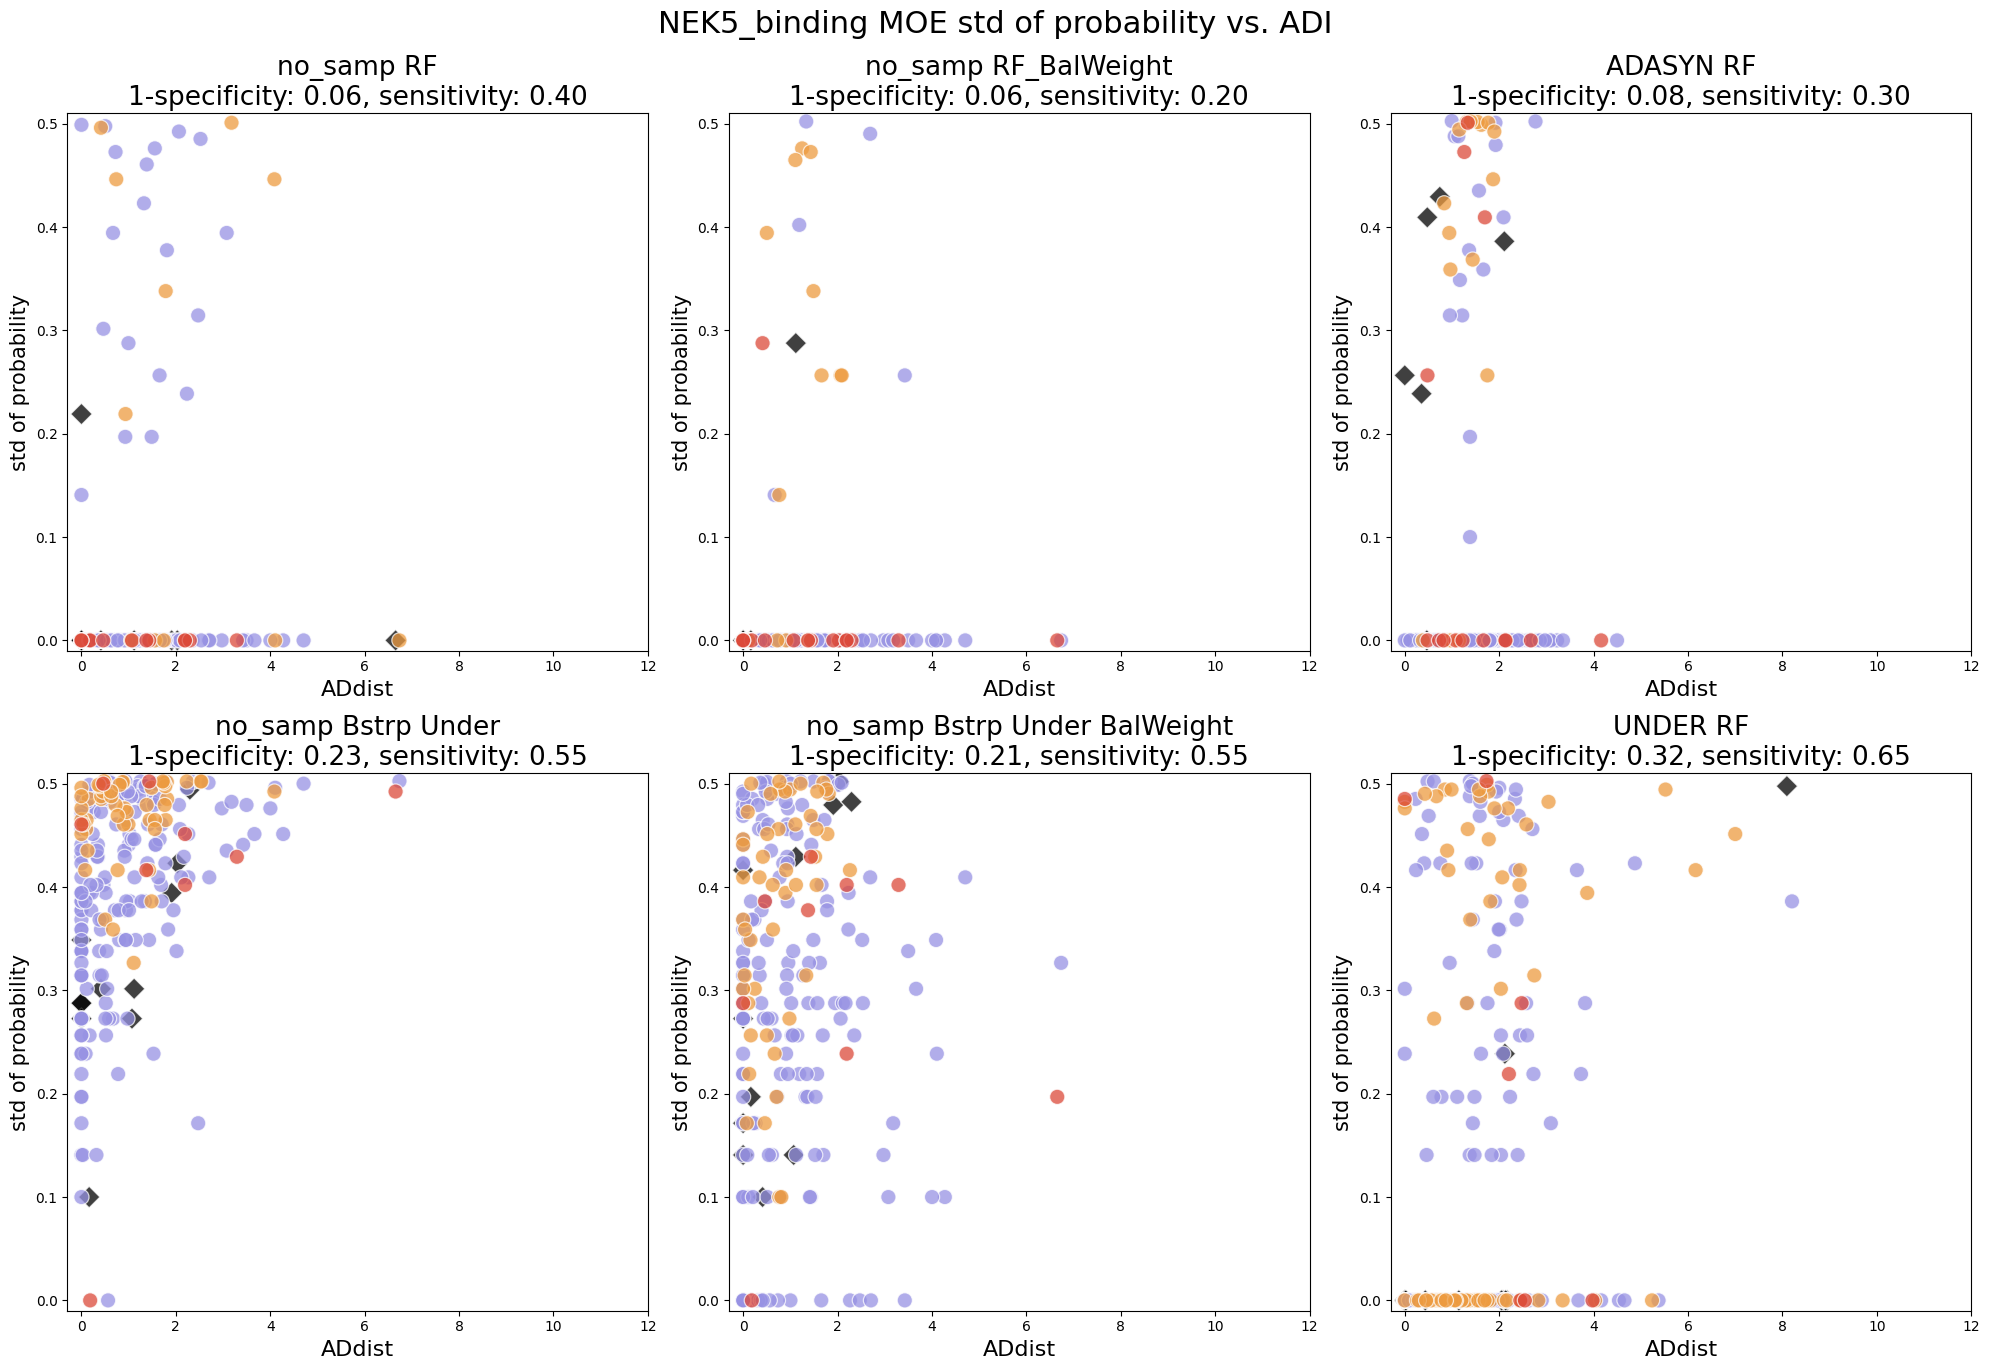

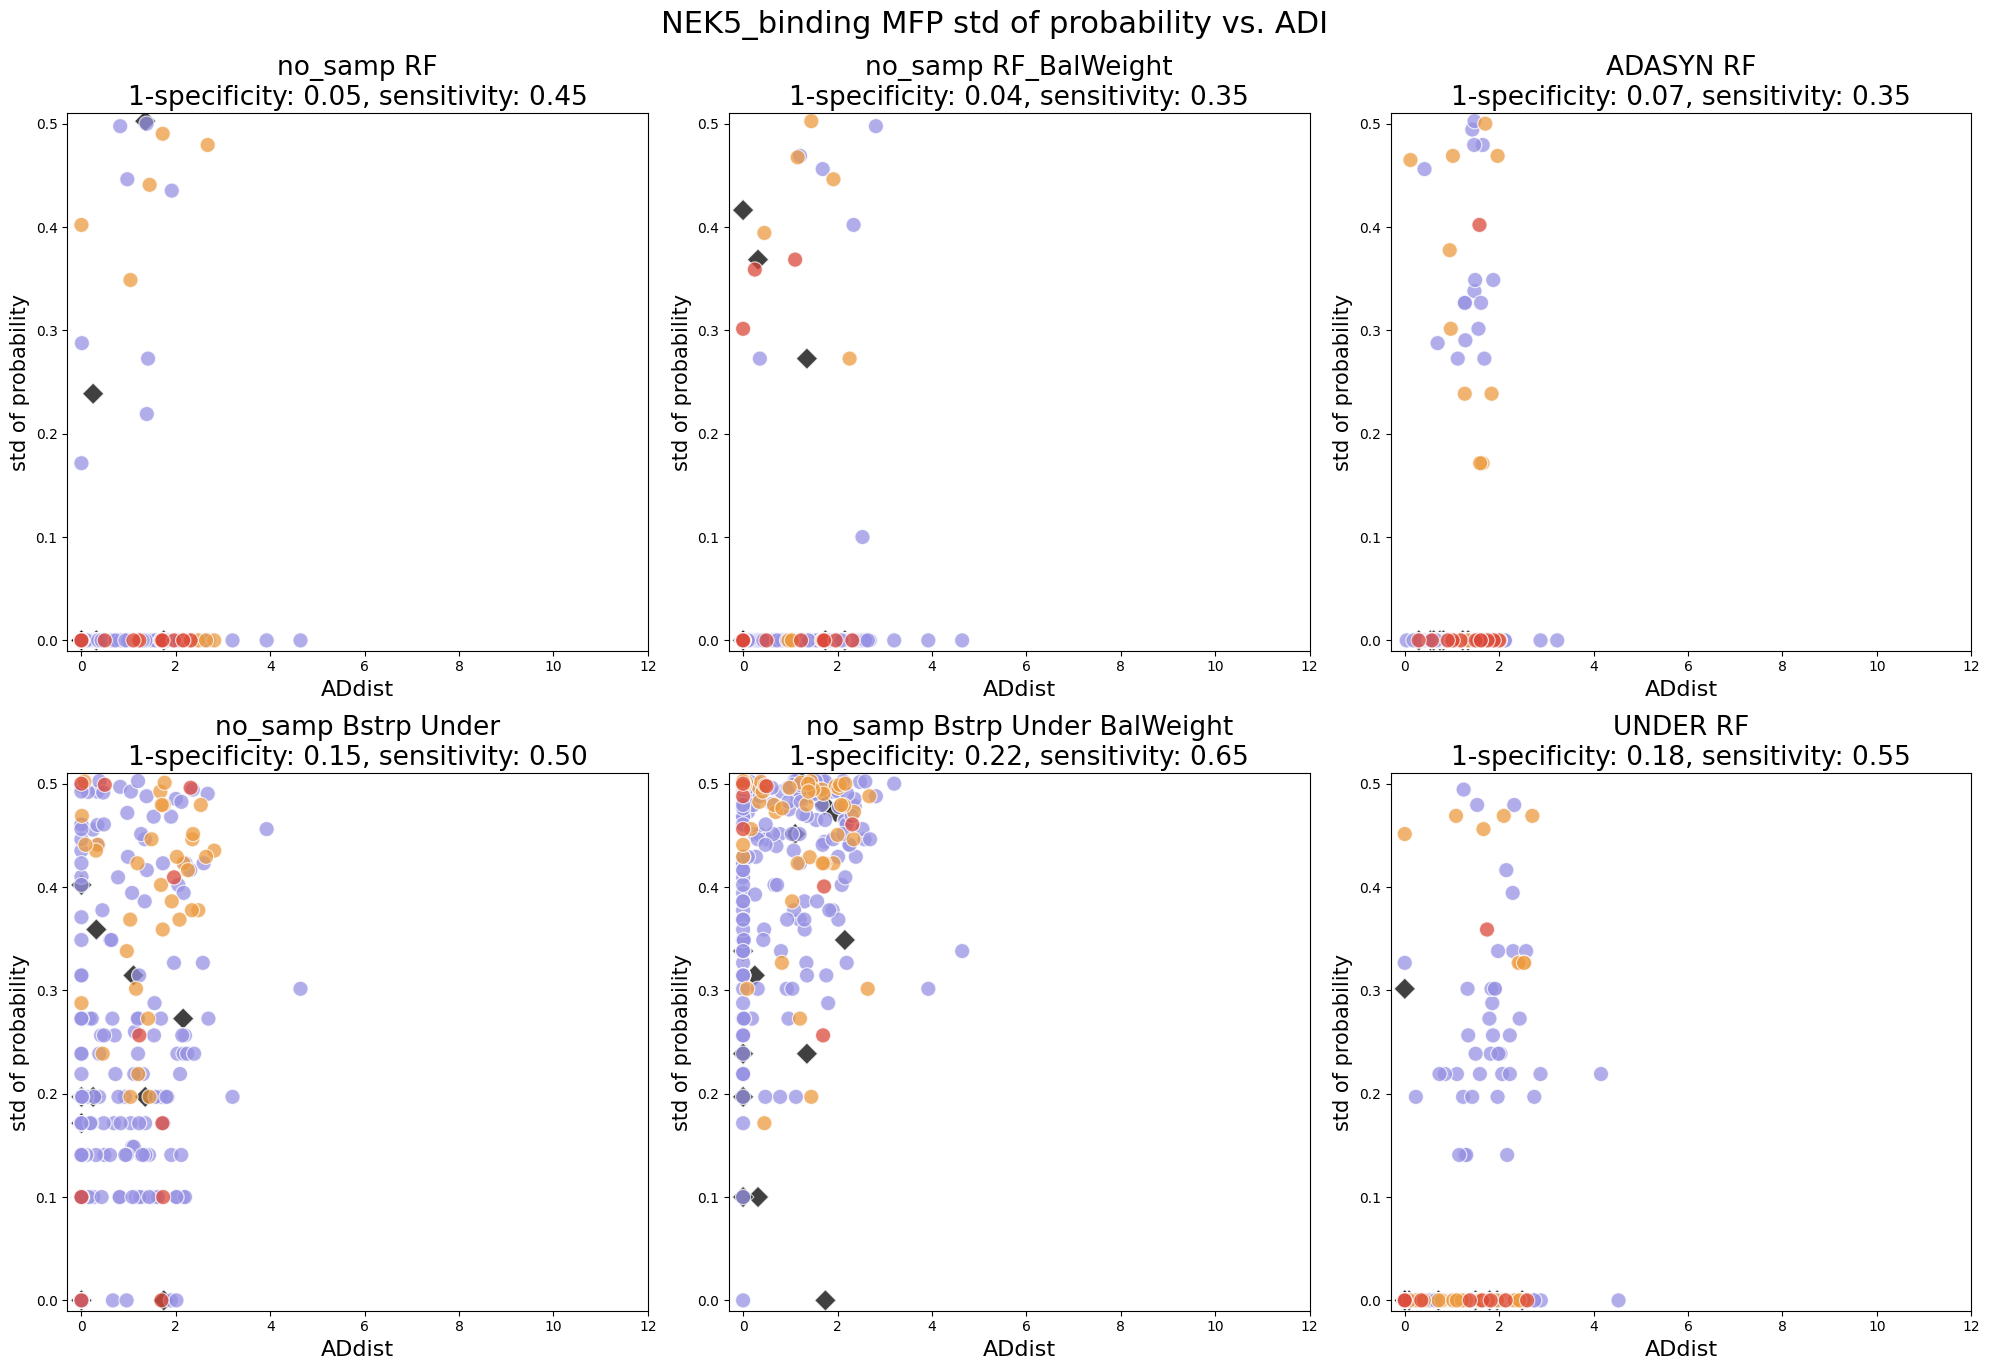

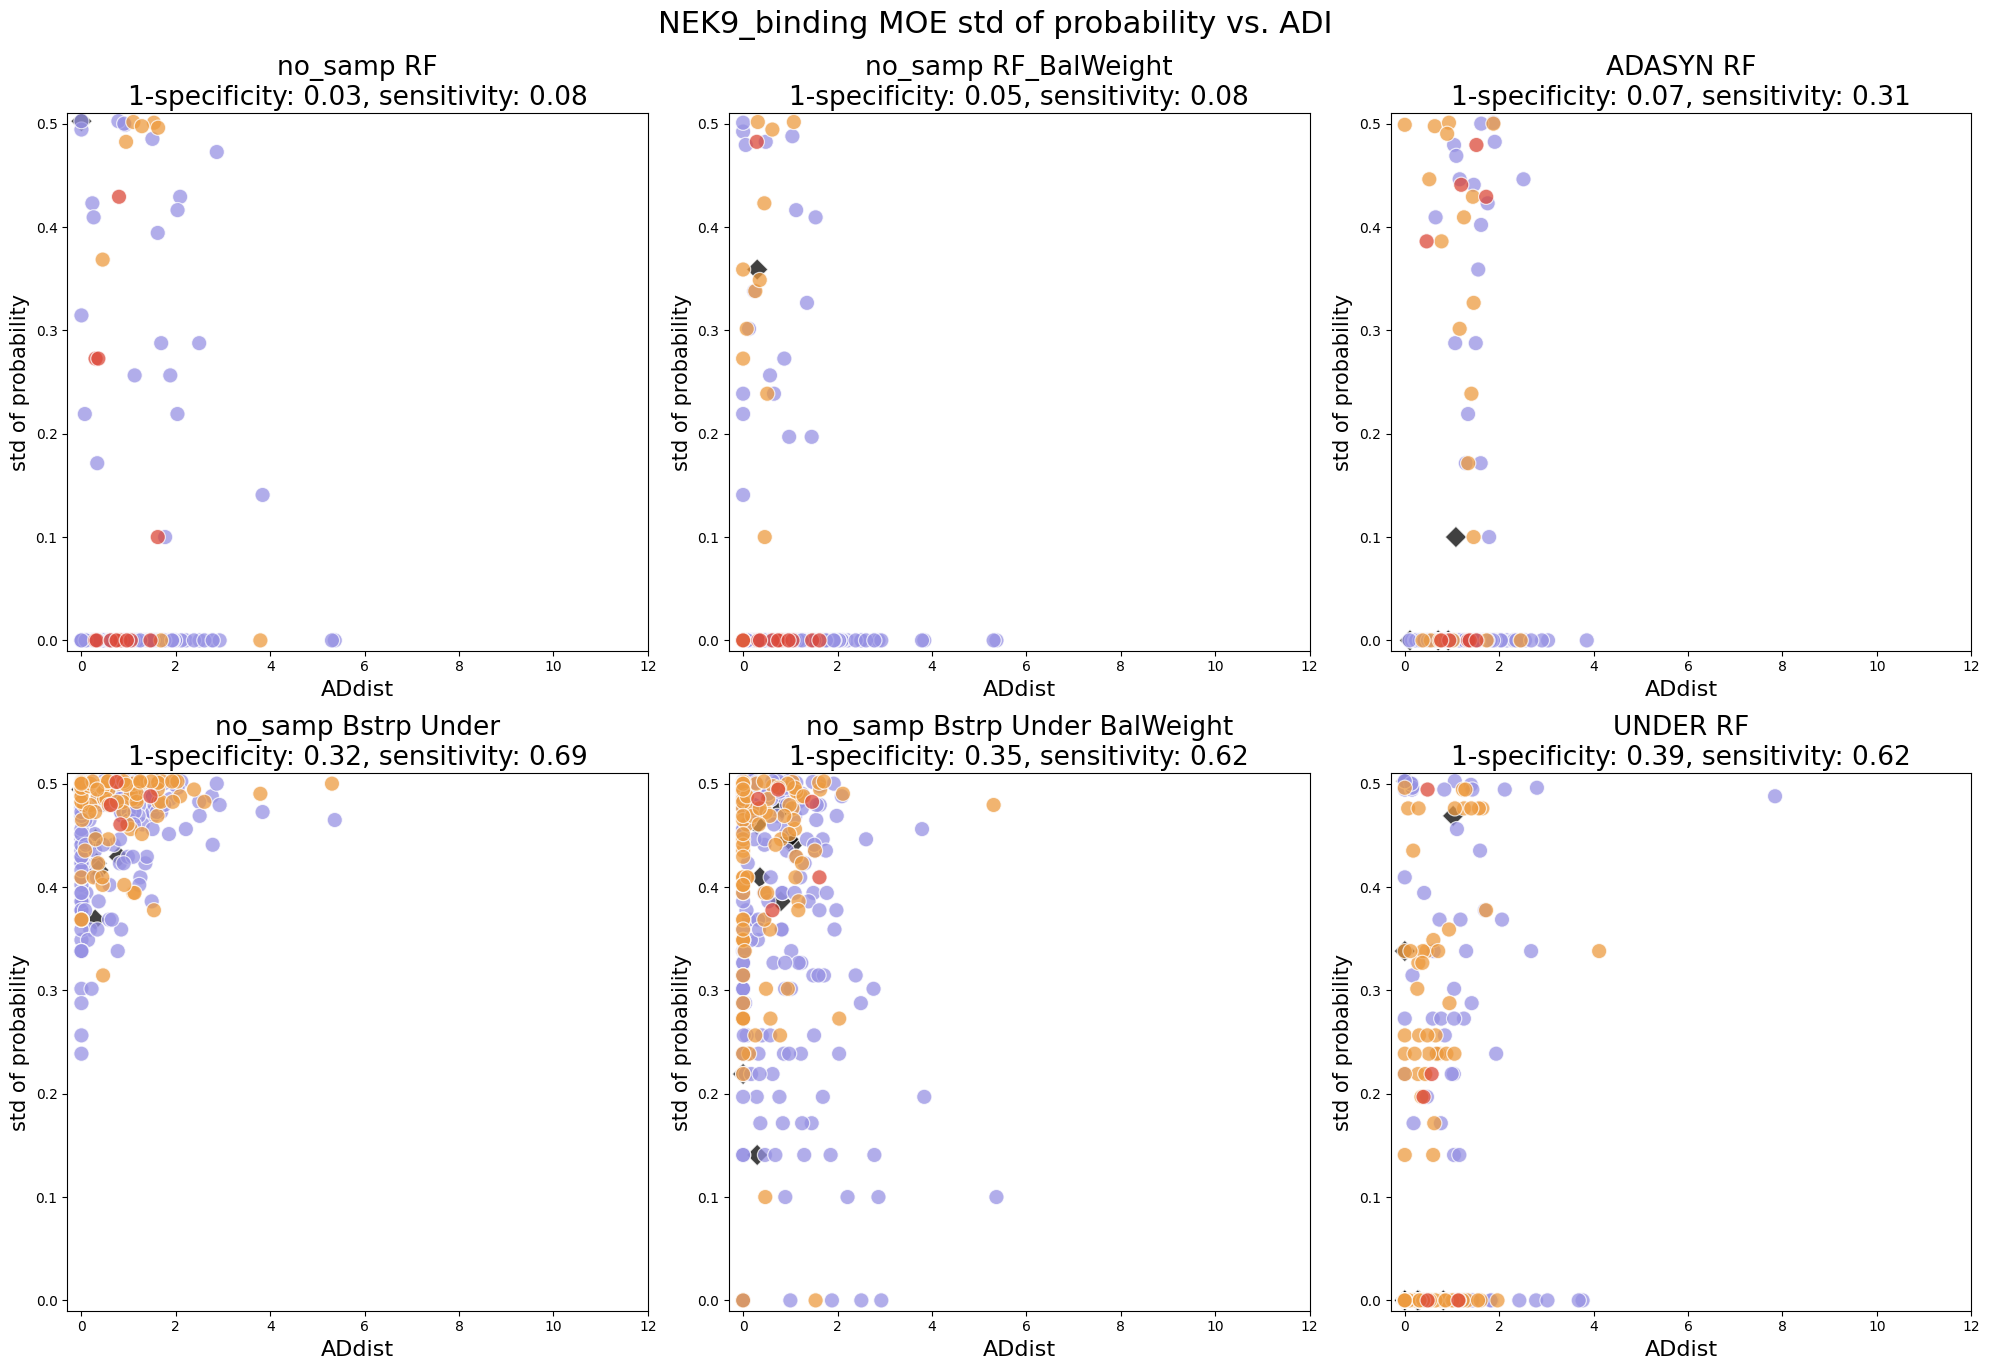

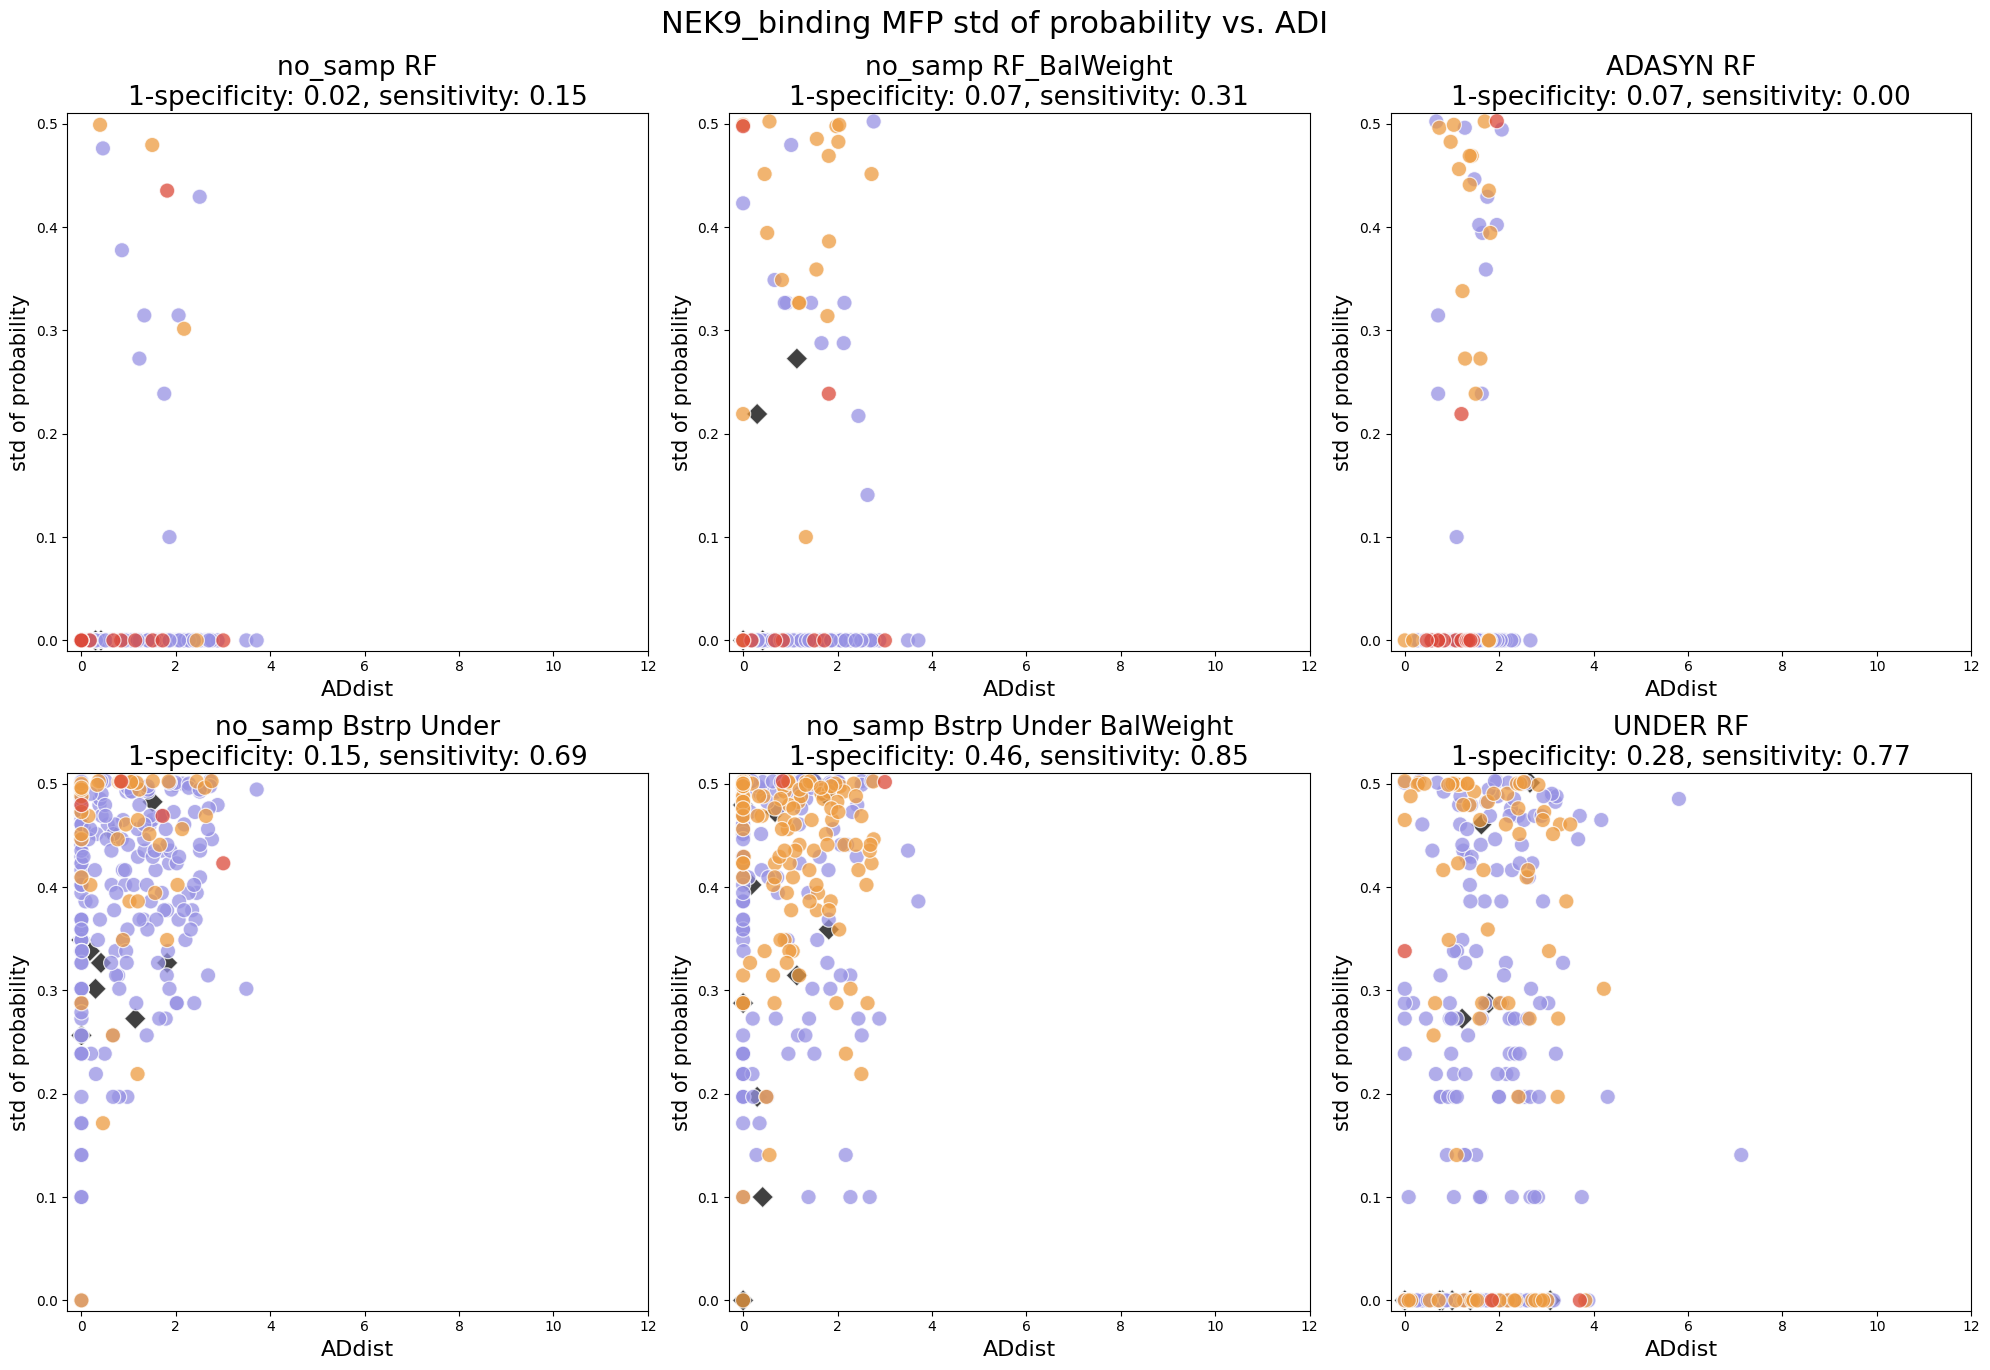

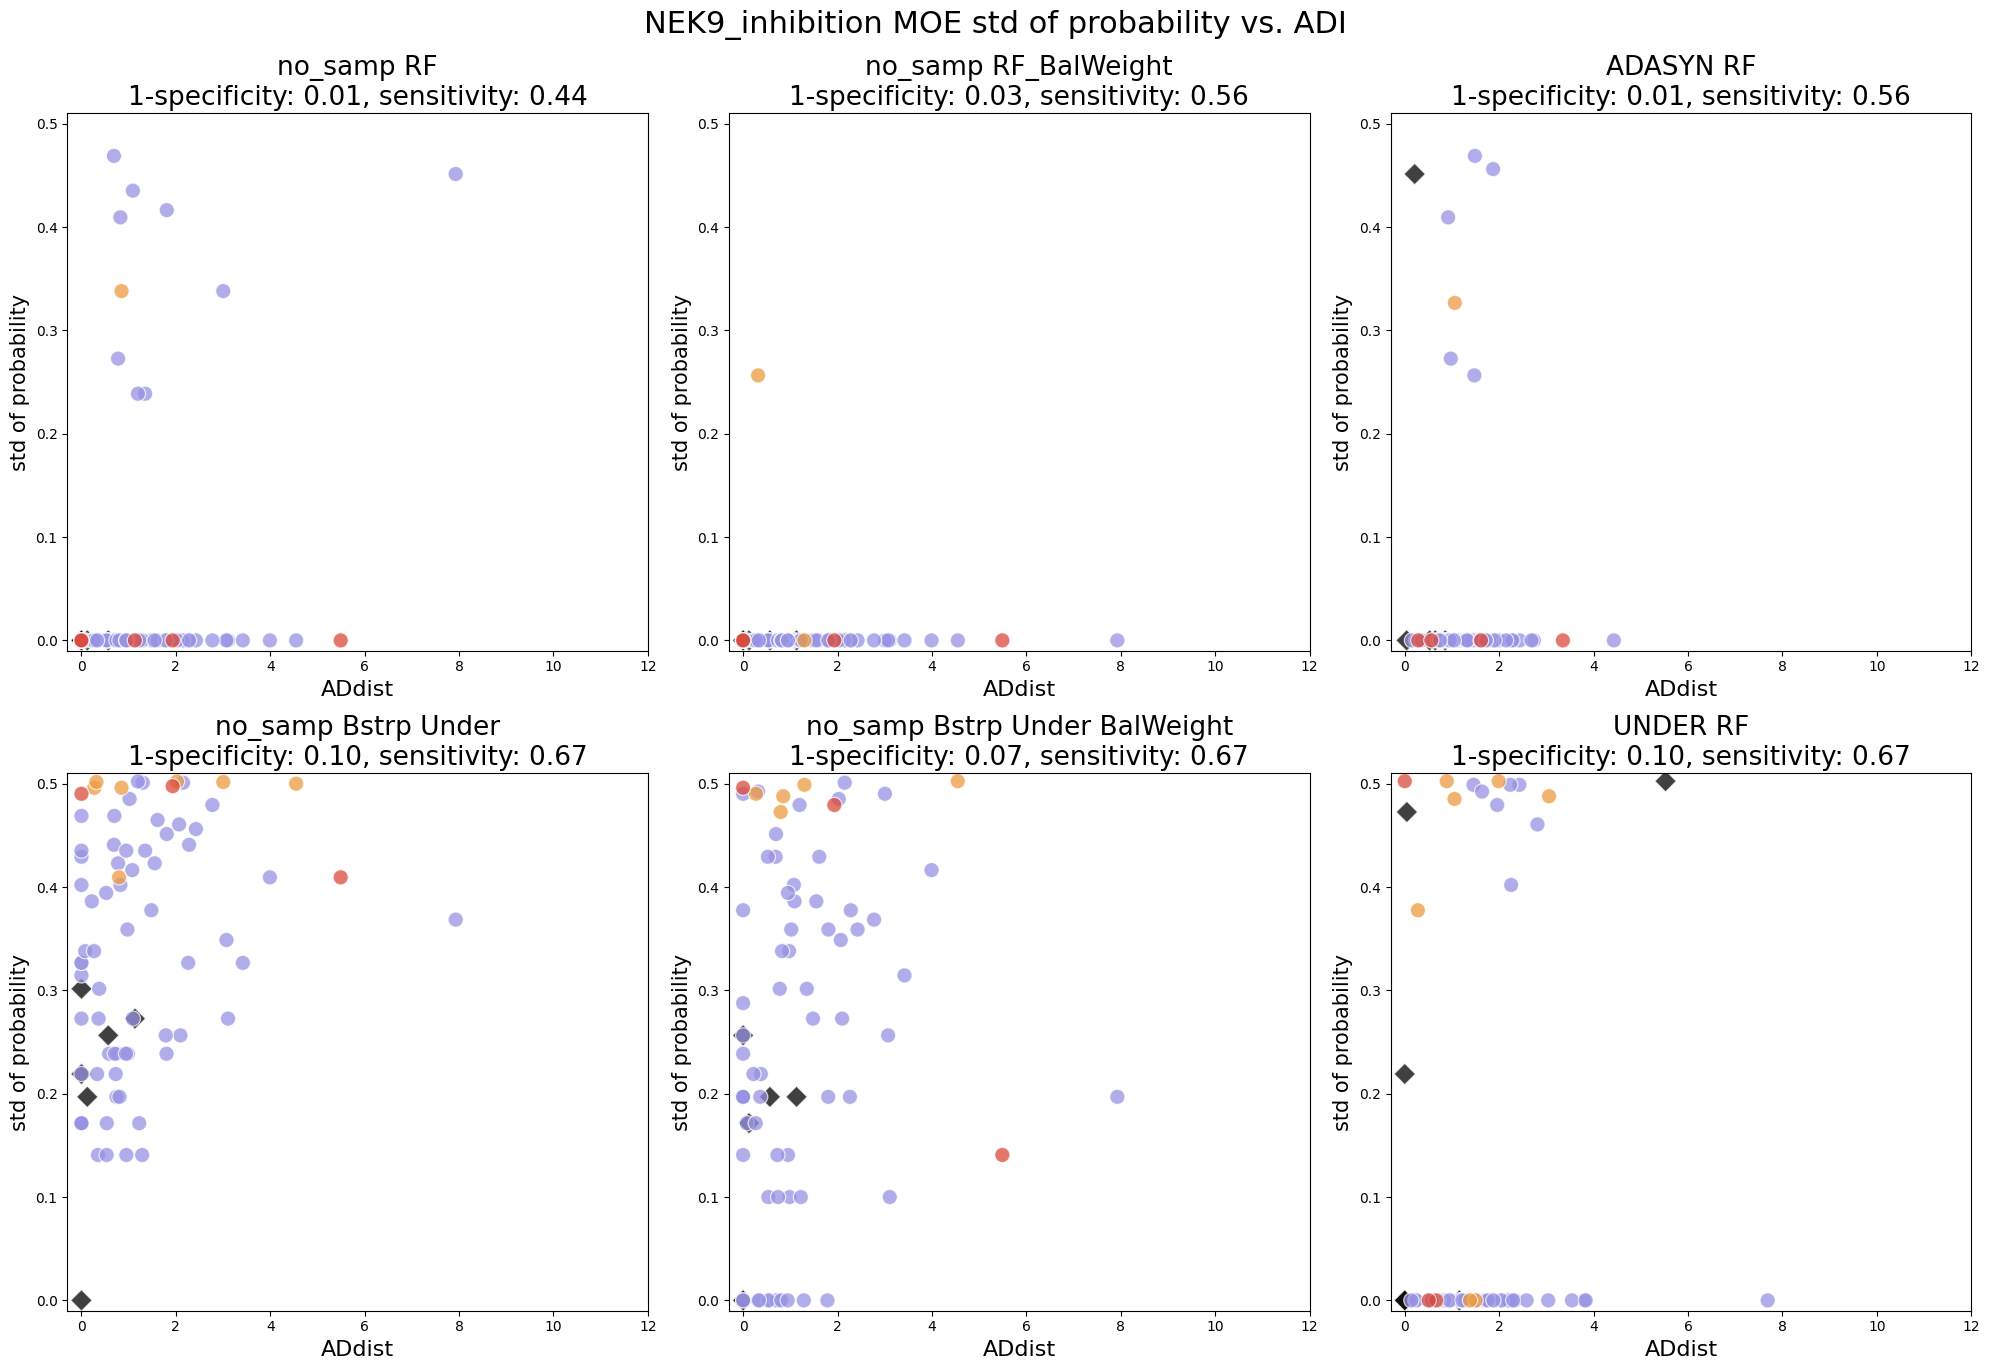

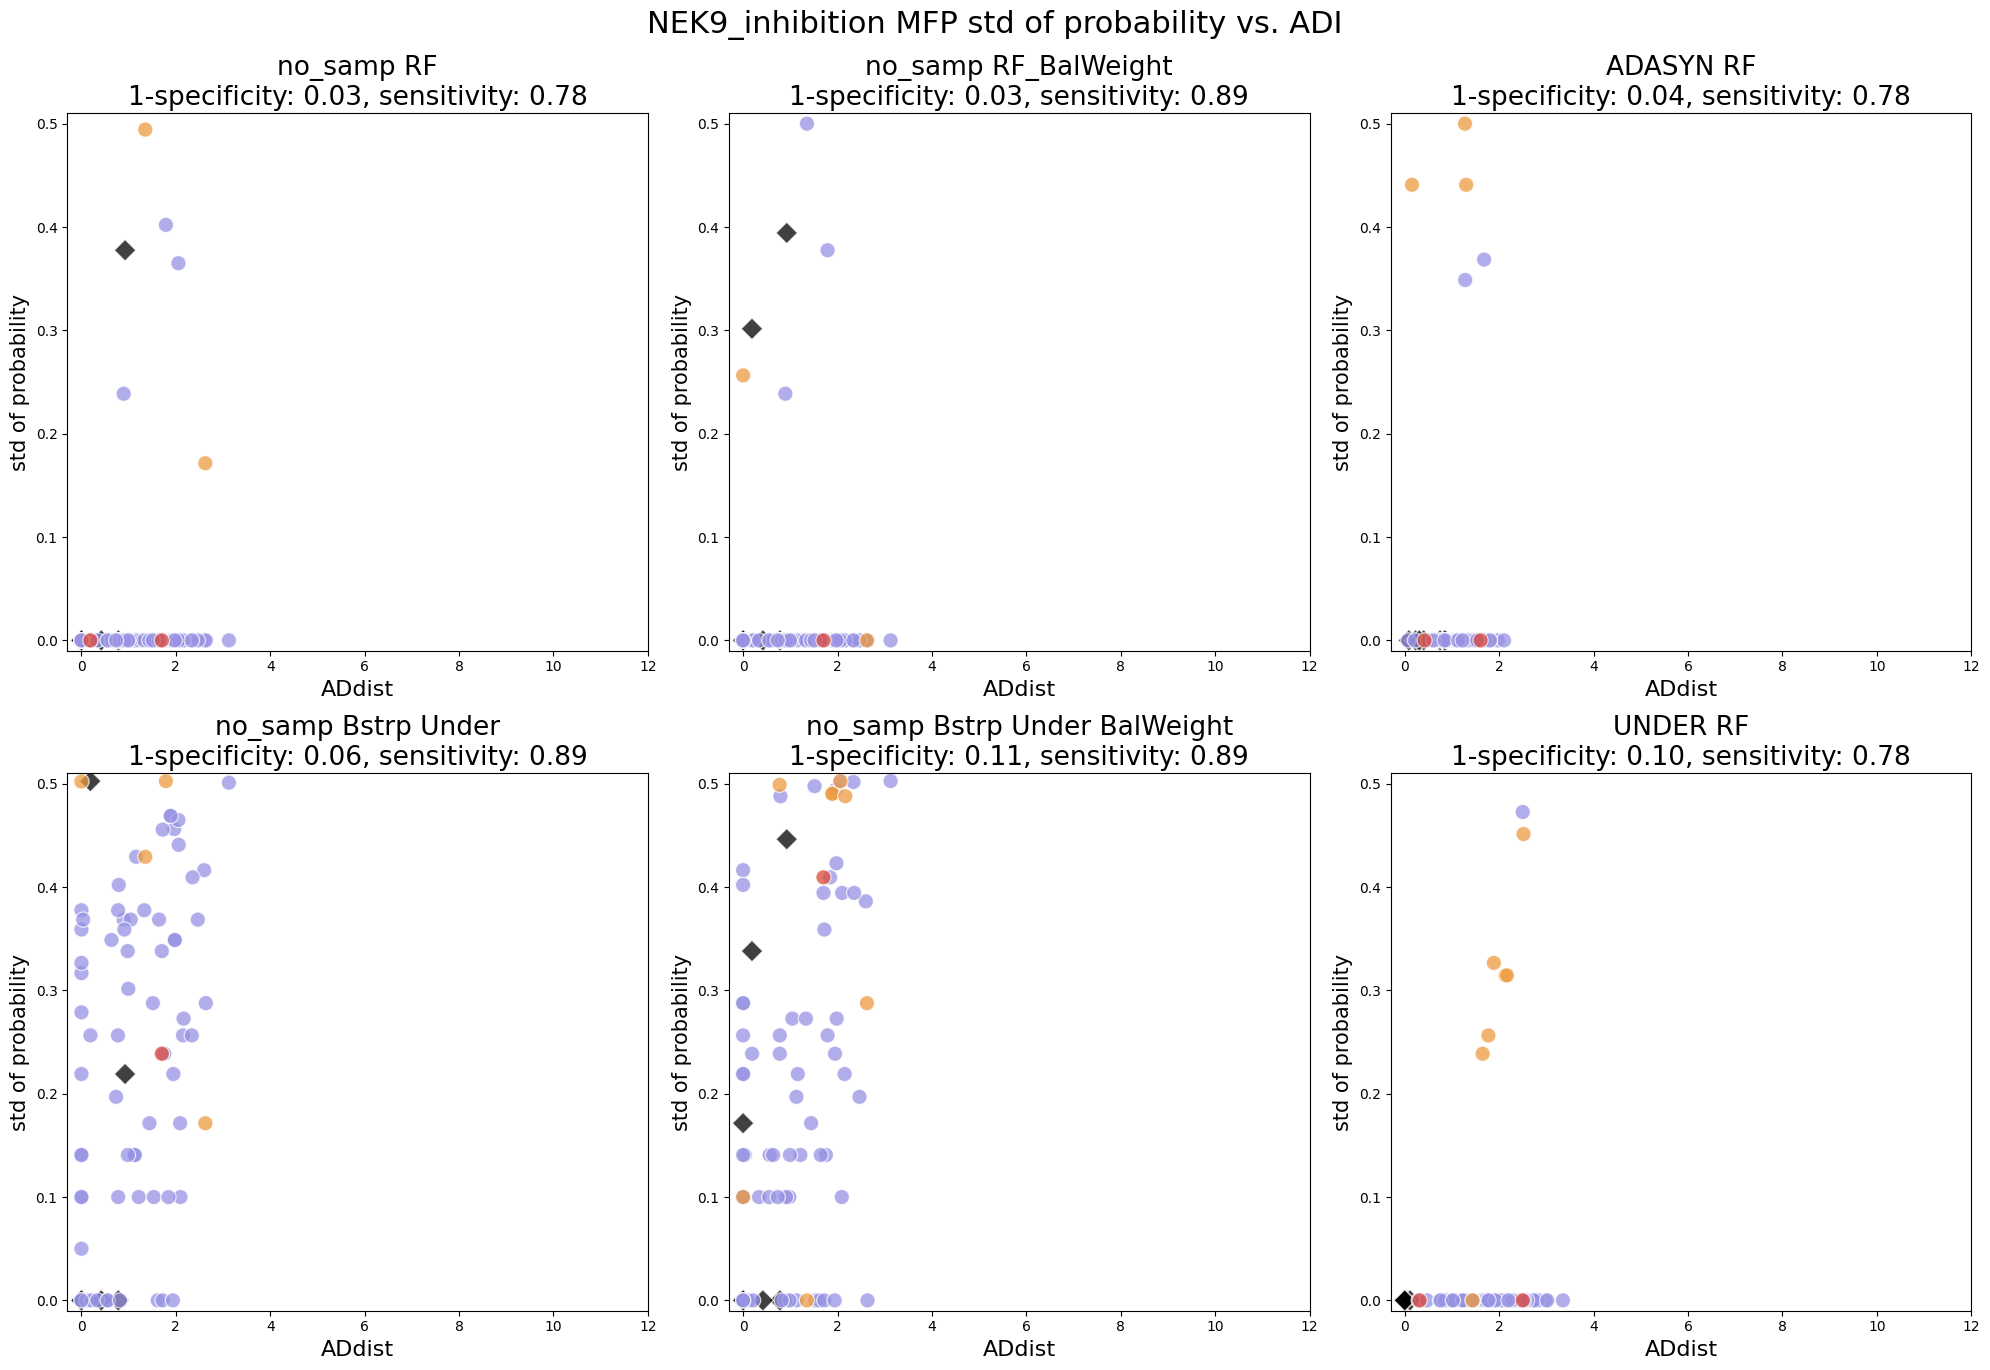

In [42]:

def change_names(df): 
    df['strategy']=df['strategy'].replace('none_scaled', 'no_samp') 
    df['strategy']=df['strategy'].replace('BRFC', 'Bstrp Under') 
    df['strategy']=df['strategy'].replace('BRFC_BCW', 'Bstrp Under BalWeight') 
    df['strategy'] = df['strategy'].replace('RF_BCW','RF_BalWeight')
    return df
    
sampling_combos = [('none_scaled','RF'),('none_scaled','RF_BCW'),('ADASYN','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF')]
name_strat_lookup={'none_scaled': 'no_samp', 'RF': 'RF', 'RF_BCW': 'RF_BalWeight', 'BRFC': 'Bstrp Under', 'BRFC_BCW':'Bstrp Under BalWeight',
                  'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}
figure_path5=f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/'
for nek in neks:
    for feat in feats: 
 
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
        fig.suptitle(f'{nek} {feat} std of probability vs. ADI', fontsize=22,y=0.94)
        count=0
        for count, (samp,rf) in enumerate(sampling_combos):
            row = count//3
            col = count%3
            ax =axes[row,col]
            count += 1
            root_name = f'{nek}_{feat}_{samp}'
            results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{rf}_prod_test.csv')
            data_df = pd.read_csv(f'{datapath}{root_name}.csv')
            with open(f'{results_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                model = pickle.load(f) 
            train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ(results_df,data_df,model)
            results_df['1-specificity'] = 1-results_df['specificity'] 
            true_labels =results_df['y'].to_numpy()
            results_df=change_names(results_df)

            df = pd.DataFrame({'prediction': results_df['prediction'],'std0': std0,'std1': std1,'ADdist': test_dist,
                'feat_type': results_df['feat_type'], 'sensitivity':results_df['recall'], '1-specificity': results_df['1-specificity']})
            samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
            title = f'{samp_label}\n1-specificity: {results_df["1-specificity"].iloc[0]:.2f}, sensitivity: {results_df["recall"].iloc[0]:.2f}'
            RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax)
    

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        fig.savefig(f'{figure_path5}{nek}_{feat}_RF_UQ_scatter.png', bbox_inches='tight')